Jako predyktor wykorzystamy pole ciśnienia atmosferycznego, w postaci tabeli wartości w siatce współrzędnych geograficznych 2.5 x 2.5 stopnia [sprawdzimy wartości rzeczywiste na poziomie morza i pole geopotencjału 500 hPa] 
Zmienne objaśniane to średnia dobowa temperatura powietrza w Warszawie lub średnia dobowa wysokość opadu atmosferycznego [do dyspozycji są jeszcze:  dobowy indeks prędkości wiatru, średnia dobowa ilość energii słonecznej na 1 m2 powierzchni, indeks bioklimatyczny]. 
Ogólny plan pracy wygląda następująco:
1.  określenie i wybór najbardziej istotnych cech z pola predyktora, a więc pewien rodzaj analizy czynnikowej/korelacyjnej żeby zawęzić ilość wektorów wejściowych do sensownego minimum. Tak naprawdę predyktorem jest jedna zmienna więc chyba wystarczy współczynnik korelacji liniowej Pearsona, ale jestem otwarty na wszelkie sugestie. 
2.  przygotowanie sekwencji danych wejściowych w postaci zbioru uczącego i walidacyjnego, z zastosowaniem backtestingu - czyli podziału całego szeregu na odcinki w celu lepszej generalizacji modelu
3.  napisanie funkcji tworzącej model sieci rekurencyjnej (LSTM/GRU) i automatycznie losującej hiperparametry (Random Search)  oraz realizującej właściwe uczenie sieci, z możliwymi elementami wizualizacji procesu uczenia i kontroli np. early stopping
4.  walidacja prognoz i ostateczne sprawdzenie dokładności na nowych danych
5. wnioski

Główne pytania na jakie chcemy znaleźć odpowiedź:
1. Na ile dokładnie można w taki sposób prognozować warunki pogodowe i w jakim horyzoncie czasowym (tzn. np. dobrym wynikiem  będzie przewidzenie temperatury na jutro z dokładnością do 1 stopnia, ale równie dobrym będzie przewidzenie średniej temperatury np. grudnia z dokładnością +/- 5 stopni).
2. Jak przygotować dane wejściowe: jak długa ma być sekwencja, czy powinna być przesunięta w czasie, jak poprawnie zastosować backtesting, na ile normalizacja albo inne zabiegi inżynieryjne mają wpływ na konwergentność i dokładność modelu
3. Jaka konfiguracja sieci jest optymalna pod względem dokładności i kosztu obliczeniowego (ilość neuronów, liczba warstw, rodzaj optymalizatora, wielkość batchsize, długość treningu, dropout), czy LSTM ma przewagę nad GRU, ile razy trzeba powtórzyć elementarne modelowanie żeby uznać wynik za istotny (czyli jaka jest wariancja wyników względem konfiguracji sieci) ...

Jako podstawę budowanego przez nas modelu statystycznego do dyspozycji mamy codzienne obserwacje pola ciśnienia z ostatnich 15 lat w siatce współrzędnych 2.5 x 2.5 stopnia w dwóch zbiorach:
(1) P_SLP_-60_80-90_90-0115.csv   - ciśnienie rzeczywiste (w hPa) skorygowane do poziomu morza  
(2) P_HGT_-60_80-90_90-0115.csv    -wysokość pola geopotencjału 500hPa, czyli wysokość (w km) umownej płaszczyzny wyznaczającej ciśnienie 500hPa.  

Pliki można pobrać stąd: https://drive.google.com/open?id=121d5eynoVlFc8sOei0kvmwKzd7Q4z7YS

Naszym celem będzie **znalezienie takich punktów geograficznych, w których wahania ciśnienia są najlepiej skorelowane z temperaturą lub opadami w Warszawie.** Plik .csv ma jedną linią nagłówka i ";" jako separator wartości.  4161 wierszy  odpowiada  kolejnym polom  mapy,  a 5480 kolumn (z których pierwsze trzy to zmienne porządkowe) zawiera wartości szeregu czasowego obserwacji dla każdego pola.

Wartości elementów meteo dla Warszawy znajdują się w pliku **meteo_W.csv** (można np. zamówić ze strony https://globalweather.tamu.edu/), interesują nas kolumny TSERD i OPAD, zawierające wartości średniej dobowej temperatury powietrza oraz średniej dobowej sumy opadów.

Zadanie polega na **obliczeniu współczynnika korelacji liniowej Pearsona pomiędzy szeregiem zmiennej meteo a szeregiem wartości ciśnienia dla każdego pola mapy, w dziesięcioleciu 2001-2010.**

W tym celu należy: 
1. z danych meteo wyciągnąć wektor wartości przycięty do lat 2001-2010;
2. następnie iteracyjnie dla każdego pola z danych ciśnienia wyciągnąć wektor ciśnienia (też odpowiedniej długości),
3. policzyć wsp. korelacji między tym wektorem a wektorem meteo wraz z krytycznym prawdopodobieństwem testowym (p-value),
4. obliczone dla pól wartości zapisać, będą jeszcze potrzebne.
5. Na koniec podać współrzędne 5 pól o najwyższym wsp. korelacji  (dodatnim i ujemnym), istotnym na poziomie lepszym niż 0.01.

HGT, TSRED 

dobrze byłoby napisać funkcję korelującą wycinki macierzy tak, żeby w miarę łatwo sprawdzać też inne okresy (długości wektorów).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

meteo_W = pd.read_csv('./data/meteo_W.csv', sep=';')
del meteo_W['Longitude']
del meteo_W['Latitude']
meteo_W.DATA = pd.to_datetime(meteo_W.DATA).dt.normalize()
meteo_W['date'] = meteo_W['DATA']
del meteo_W['DATA']

hgt = pd.read_csv('./data/P_HGT_-60_80-90_90-0115.csv', sep=';', index_col=0)
#slp = pd.read_csv('./data/P_SLP_-60_80-90_90-0115.csv', sep=';', index_col=0)

hgt['latitude'] = hgt['latitude'].astype('category')
hgt['longitude'] = hgt['longitude'].astype('category')

hgt.tail()
hgt.shape

meteo_W.head()
meteo_W.shape

waw_x = 20.9375
waw_y = 52.298302

1. z danych meteo wyciągnąć wektor wartości przycięty do lat 2001-2010;
2. następnie iteracyjnie dla każdego pola z danych ciśnienia wyciągnąć wektor ciśnienia (też odpowiedniej długości),
3. policzyć wsp. korelacji między tym wektorem a wektorem meteo wraz z krytycznym prawdopodobieństwem testowym (p-value), obliczone dla pól wartości zapisać, będą jeszcze potrzebne.
4. Na koniec podać współrzędne 5 pól o najwyższym wsp. korelacji  (dodatnim i ujemnym), istotnym na poziomie lepszym niż 0.01.

Z danych meteo wyciągnąć wektor wartości przycięty do lat 2001-2010;

In [2]:
from datetime import date, datetime

# date_from = meteo_W.date.min()
date_from = datetime.strptime('2001-01-01', "%Y-%M-%d")
date_to = datetime.strptime('2010-01-01', "%Y-%M-%d")
delta = date_to - date_from
delta

datetime.timedelta(3287)

In [3]:
hgt = hgt.iloc[:, :delta.days+2]
meteo_W = meteo_W[meteo_W.date < date_to.date()]

In [4]:
tsred_values = meteo_W.groupby('date').TSRED.mean()
tsred_values.head()
tsred_values.tail()
tsred_values = tsred_values.values
len(tsred_values)

date
2001-01-01   -2.0530
2001-01-02   -2.2615
2001-01-03    0.5690
2001-01-04    0.7725
2001-01-05    0.7560
Name: TSRED, dtype: float64

date
2009-12-27    0.9330
2009-12-28   -0.1880
2009-12-29   -0.8930
2009-12-30   -1.6695
2009-12-31   -1.8020
Name: TSRED, dtype: float64

3287

Następnie iteracyjnie dla każdego pola z danych ciśnienia wyciągnąć wektor ciśnienia (też odpowiedniej długości),

In [5]:
hgt.iloc[0,2:].head()
hgt.iloc[0,2:].tail()
hgt.iloc[0,2:].shape

2001_01_01_00    5.215
2001_01_02_00    5.138
2001_01_03_00    5.144
2001_01_04_00    5.226
2001_01_05_00    5.241
Name: 1, dtype: object

2009_12_27_00    5.181
2009_12_28_00    5.243
2009_12_29_00    5.366
2009_12_30_00    5.392
2009_12_31_00    5.369
Name: 1, dtype: object

(3287,)

Policzyć wsp. korelacji między tym wektorem a wektorem meteo wraz z krytycznym prawdopodobieństwem testowym (p-value)
Na koniec podać współrzędne 5 pól o najwyższym wsp. korelacji  (dodatnim i ujemnym), istotnym na poziomie lepszym niż 0.01.

In [6]:
from scipy.stats.stats import pearsonr

results = pd.DataFrame()
# We iterate over rows to get 
for index, row in hgt.iterrows():
    pearson = pearsonr(row.iloc[2:], tsred_values)
    results = results.append(pd.DataFrame([*row.iloc[:2], *pearson]).T)
    
results.reset_index(inplace= True, drop=True)
results.columns = ['latitude', 'longitude', 'pearson_corr', 'corr_pval']
results['pearson_corr_abs'] = (abs(results.pearson_corr))
results = results.sort_values(by='pearson_corr', ascending=False)

results.head()

latitude  longitude  pearson_corr  corr_pval  pearson_corr_abs
3185      47.5       25.0      0.808020        0.0          0.808020
3186      47.5       27.5      0.807185        0.0          0.807185
3184      47.5       22.5      0.804484        0.0          0.804484
3259      50.0       27.5      0.804009        0.0          0.804009
3258      50.0       25.0      0.803297        0.0          0.803297

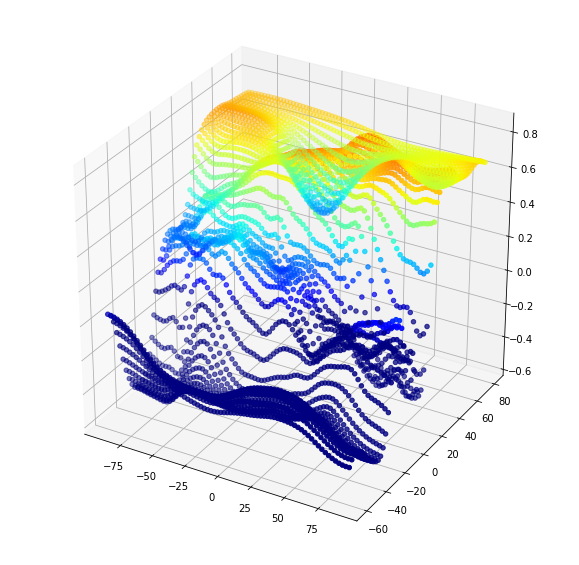

In [57]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(results.longitude, results.latitude, results.pearson_corr.values, color=plt.cm.jet(results.pearson_corr.values))
# ax.view_init(elev=25., azim=0)

In [61]:
from matplotlib import animation
def init():
    fig = plt.figure()
    ax = Axes3D(fig)
    p = ax.scatter(results.longitude, results.latitude, results.pearson_corr.values, color=plt.cm.jet(results.pearson_corr.values))
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

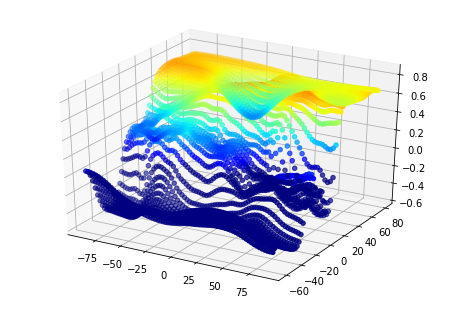

In [62]:
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
anim

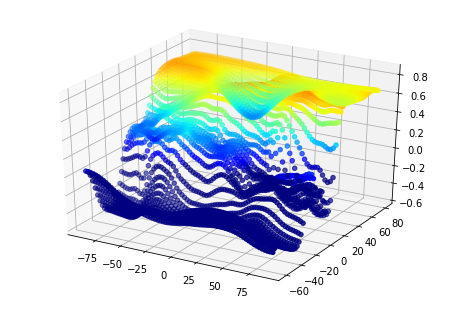

In [63]:
from IPython.display import HTML
HTML(anim.to_html5_video())

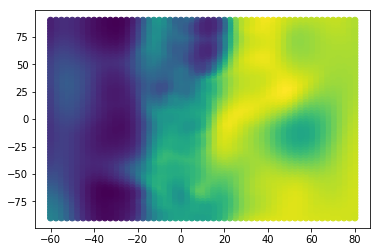

In [32]:
scatter = plt.scatter(results.longitude, results.latitude, c=results.pearson_corr)

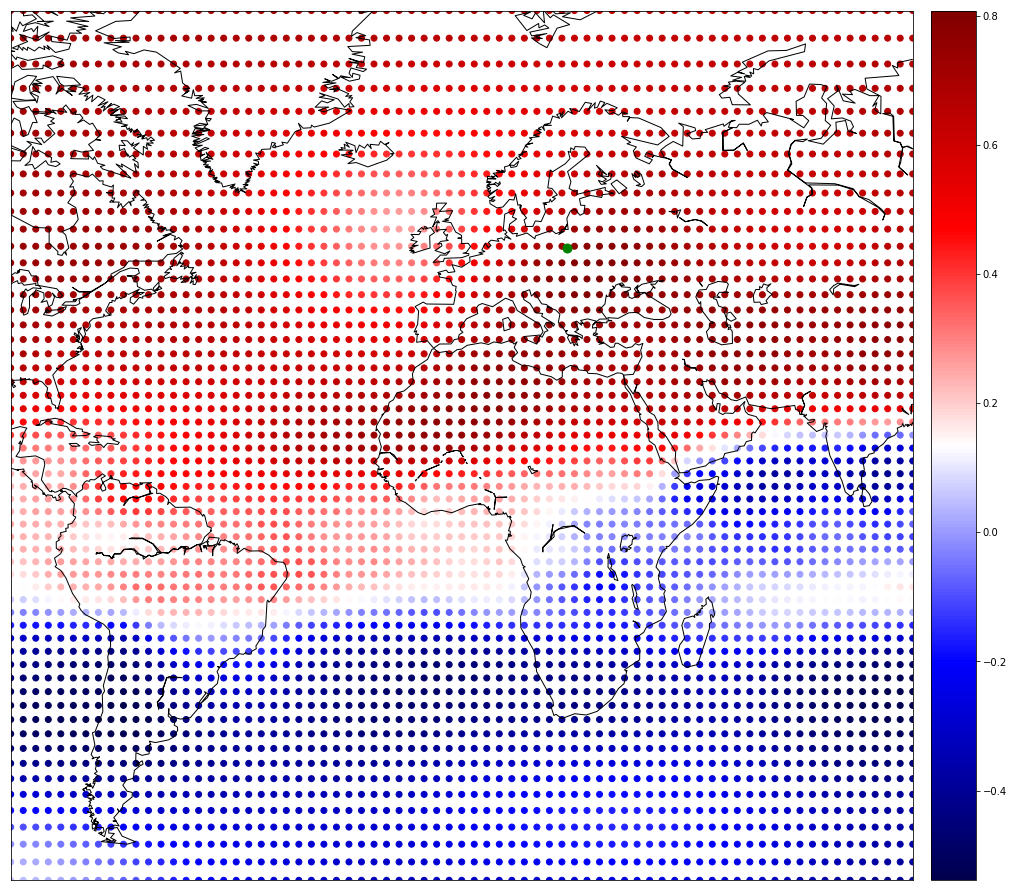

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pylab

fig = plt.figure(figsize=(20, 16))
map_axis = fig.add_subplot(111)
map = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-90, urcrnrlon=90,resolution='c')

map.drawcoastlines()
# map.drawparallels(np.arange(-90.,91.,30.))
# map.drawmeridians(np.arange(-180.,181.,60.))

x, y = map(waw_x, waw_y)
map.plot(x, y, 'go', markersize=9)

x, y = map(results.longitude.values, results.latitude.values)
map.scatter(x, y, c=results.pearson_corr.values, cmap=pylab.cm.seismic)
map.colorbar(location='right')

# plt.savefig('hgt_tsred.png')

In [59]:
results.iloc[:, :3].pivot_table(index = 'latitude', columns='longitude', values='pearson_corr').head()

longitude     -90.0     -87.5     -85.0     -82.5     -80.0     -77.5  \
latitude                                                                
-60.0      0.051881  0.047817  0.041478  0.032511  0.020997  0.007030   
-57.5      0.032463  0.028321  0.021873  0.012875  0.001259 -0.012924   
-55.0     -0.017087 -0.021528 -0.028209 -0.037115 -0.048506 -0.062666   
-52.5     -0.092704 -0.097592 -0.104285 -0.112859 -0.123217 -0.135755   
-50.0     -0.184039 -0.188917 -0.195604 -0.203363 -0.212347 -0.222263   

longitude     -75.0     -72.5     -70.0     -67.5    ...         67.5  \
latitude                                             ...                
-60.0     -0.009575 -0.028253 -0.048870 -0.070819    ...    -0.344292   
-57.5     -0.029762 -0.048850 -0.069613 -0.091288    ...    -0.308984   
-55.0     -0.079468 -0.098720 -0.119488 -0.140756    ...    -0.294089   
-52.5     -0.150764 -0.167889 -0.186411 -0.204896    ...    -0.295104   
-50.0     -0.233344 -0.245813 -0.259065 -0.272363    ...    -0.308305   

longitude      70.0      72.5      75.0      77.5      80.0      82.5  \
latitude                                                                
-60.0     -0.357974 -0.370865 -0.382487 -0.392854 -0.401610 -0.408440   
-57.5     -0.323300 -0.336815 -0.349252 -0.360277 -0.369768 -0.376986   
-55.0     -0.308203 -0.321974 -0.334981 -0.346562 -0.356227 -0.363246   
-52.5     -0.308775 -0.322548 -0.335670 -0.347313 -0.356811 -0.363497   
-50.0     -0.321757 -0.335218 -0.347886 -0.358850 -0.367538 -0.373569   

longitude      85.0      87.5      90.0  
latitude                                 
-60.0     -0.413012 -0.415119 -0.414984  
-57.5     -0.381814 -0.383929 -0.383481  
-55.0     -0.367454 -0.368716 -0.367222  
-52.5     -0.367182 -0.367816 -0.365701  
-50.0     -0.376833 -0.377219 -0.375020  

[5 rows x 73 columns]

In [218]:
pearson_corr_vals = results.iloc[:, :3].pivot_table(index = 'latitude', columns='longitude', values='pearson_corr').values
pearson_corr_vals

array([[ 0.05188069,  0.04781656,  0.04147757, ..., -0.4130117 ,
        -0.41511863, -0.41498372],
       [ 0.03246292,  0.02832098,  0.02187337, ..., -0.38181369,
        -0.38392871, -0.3834813 ],
       [-0.01708676, -0.02152838, -0.02820911, ..., -0.36745431,
        -0.36871608, -0.36722181],
       ..., 
       [ 0.71338852,  0.71242664,  0.71127459, ...,  0.67119571,
         0.6742753 ,  0.67708405],
       [ 0.71038612,  0.71061139,  0.71069784, ...,  0.65854624,
         0.66011123,  0.66145719],
       [ 0.70609569,  0.70716091,  0.7081004 , ...,  0.64598821,
         0.64663069,  0.64712463]])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pylab

fig = plt.figure(figsize=(20, 16))
map_axis = fig.add_subplot(111)
map = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-90, urcrnrlon=90,resolution='c')

map.drawcoastlines()
# map.drawparallels(np.arange(-90.,91.,30.))
# map.drawmeridians(np.arange(-180.,181.,60.))

x, y = map(waw_x, waw_y)
map.plot(x, y, 'go', markersize=9)

x, y = map(*np.meshgrid(results.longitude.values, results.latitude.values))
map.pcolormesh(x, y, np.array(np.meshgrid(pearson_corr_vals, pearson_corr_vals))[0], cmap=pylab.cm.seismic)
#map.colorbar(location='right')

Text(0.5,0.98,'Intensities start_time stop_time')

c:\users\matka\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
c:\users\matka\anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


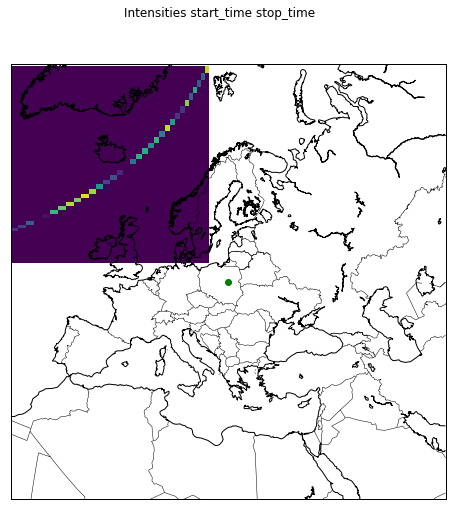

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

fig = plt.figure(figsize=(10, 8))
# Set title
fig.suptitle("Intensities {} {}".format('start_time', 'stop_time'))

map_axis = fig.add_subplot(111)
map = Basemap(
    ax = map_axis,
    width = 6500e3, height = 6500e3,
    projection='aeqd',
    lon_0 = waw_x,
    lat_0 = waw_y,
    resolution = 'l')
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()

x, y = map(waw_x, waw_y)
map.plot(x, y, 'go', markersize=6)

# Tried my best to simulate your data example. Don't be surprise if the result is ugly ...
nstep = 1
lats = np.arange(map.latmin, map.latmax, nstep)
lons = np.arange(map.lonmin, map.lonmax, nstep)
l = min(len(lats), len(lons))
lats = lats[:l]
lons = lons[:l]
intn = np.random.randint(0, 100, size=l)

# Convert coordinates
lons, lats = map(lons, lats)
LONS, LATS = np.meshgrid(lons, lats)

# The following 3 lines are just an example of the minimum you got to do before it works.
intn_array = np.zeros(LONS.shape)
for i in range(l):
    intn_array[i, i] = intn[i]
intn = intn_array

map.pcolormesh(
    LONS, LATS,
    intn_array,
    vmin = 0, vmax = 100
)
